# Creating your own dataset from Google Images

*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In this tutorial we will see how to easily create an image dataset through Google Images. **Note**: You will have to repeat these steps for any new category you want to Google (e.g once for dogs and once for cats).

In [ ]:
from fastai.vision.all import *
from nbdev.showdoc import *

## Get a list of URLs

### Search and scroll

Go to [Google Images](http://images.google.com) and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

    "canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

### Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>J</kbd> in Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>J</kbd> in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

### Create directory and upload urls file into your server

Choose an appropriate name for your labeled images. You can run these steps multiple times to create different labels.

In [ ]:
path = Config().data/'bears'
path.mkdir(parents=True, exist_ok=True)

In [ ]:
path.ls()

(#8) [/home/sgugger/.fastai/data/bears/models,/home/sgugger/.fastai/data/bears/urls_grizzly.csv,/home/sgugger/.fastai/data/bears/black,/home/sgugger/.fastai/data/bears/teddy,/home/sgugger/.fastai/data/bears/urls_teddy.csv,/home/sgugger/.fastai/data/bears/grizzly,/home/sgugger/.fastai/data/bears/urls_black.csv,/home/sgugger/.fastai/data/bears/export.pkl]

Finally, upload your urls file. You just need to press 'Upload' in your working directory and select your file, then click 'Upload' for each of the displayed files.

## Download images

Now you will need to download your images from their respective urls.

fast.ai has a function that allows you to do just that. You just have to specify the urls filename as well as the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.

In [ ]:
classes = ['teddy','grizzly','black']

In [ ]:
for c in classes:
    print(c)
    file = f'urls_{c}.csv'
    download_images(path/c, path/file, max_pics=200)

In [ ]:
# If you have problems download, try with `max_workers=0` to see exceptions:
#download_images(path/file, dest, max_pics=20, max_workers=0)

Then we can remove any images that can't be opened:

In [ ]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

## View data

In [ ]:
np.random.seed(42)
dls = ImageDataLoaders.from_folder(path, train=".", valid_pct=0.2, item_tfms=RandomResizedCrop(460, min_scale=0.75),
                                    bs=64, batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)])

In [ ]:
# If you already cleaned your data, run this cell instead of the one before
# np.random.seed(42)
# dls = ImageDataLoaders.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
#         item_tfms=RandomResizedCrop(460, min_scale=0.75), bs=64,
#         batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)])

Good! Let's take a look at some of our pictures then.

In [ ]:
dls.vocab

(#3) [black,grizzly,teddy]

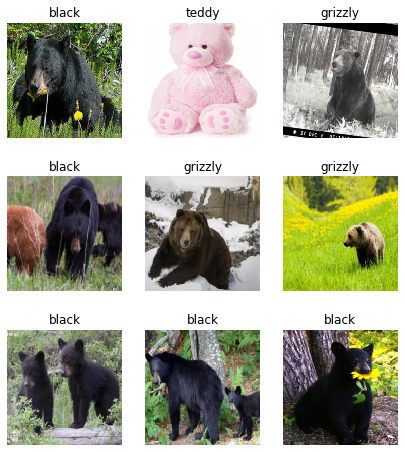

In [ ]:
dls.show_batch(rows=3, figsize=(7,8))

In [ ]:
dls.vocab, dls.c, len(dls.train_ds), len(dls.valid_ds)

((#3) [black,grizzly,teddy], 3, 439, 109)

## Train model

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.389470,0.080287,0.036697,00:04
1,0.743439,0.051549,0.018349,00:04
2,0.548818,0.048282,0.018349,00:04
3,0.427376,0.035982,0.018349,00:04


In [ ]:
learn.save('stage-1')

In [ ]:
learn.unfreeze()

If the plot is not showing try to give a start and end learning rate:

`learn.lr_find(start_lr=1e-5, end_lr=1e-1)`

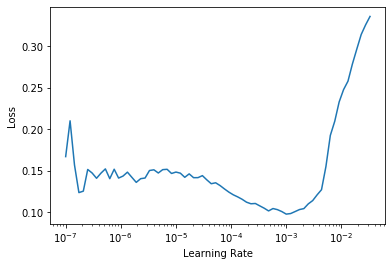

In [ ]:
learn.lr_find()

In [ ]:
learn.load('stage-1')

In [ ]:
learn.fit_one_cycle(2, lr_max=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.181978,0.025317,0.000000,00:04
1,0.131894,0.015477,0.000000,00:05


In [ ]:
learn.save('stage-2')

## Interpretation

In [ ]:
learn.load('stage-2');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

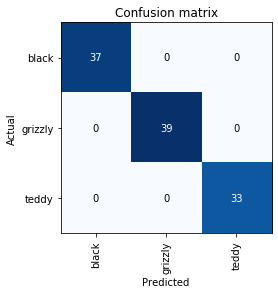

In [ ]:
interp.plot_confusion_matrix()

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [ ]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [ ]:
defaults.device = torch.device('cpu')

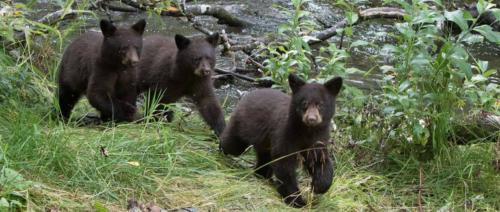

In [ ]:
img = Image.open(path/'black'/'00000021.jpg')
img

We create our `Learner` in production environment like this, just make sure that `path` contains the file 'export.pkl' from before.

In [ ]:
learn = torch.load(path/'export.pkl')

In [ ]:
pred_class,pred_idx,outputs = learn.predict(path/'black'/'00000021.jpg')
pred_class

'black'

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = PILImage.create(bytes)
    _,_,probs = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.dls.vocab, map(float, probs)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs

### Learning rate (LR) too high

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(1, lr_max=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,11.912274,268656672.000000,0.614679,00:05


### Learning rate (LR) too low

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

Previously we had this result:

```
Total time: 00:57
epoch  train_loss  valid_loss  error_rate
1      1.030236    0.179226    0.028369    (00:14)
2      0.561508    0.055464    0.014184    (00:13)
3      0.396103    0.053801    0.014184    (00:13)
4      0.316883    0.050197    0.021277    (00:15)
```

In [ ]:
learn.fit_one_cycle(5, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,2.115399,1.515124,0.642202,00:04
1,1.988798,1.327677,0.605505,00:04
2,1.925547,1.247692,0.587156,00:05
3,2.001188,1.212484,0.559633,00:04
4,1.998247,1.214754,0.568807,00:05


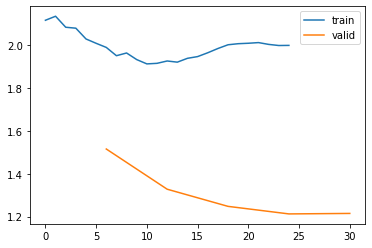

In [ ]:
learn.recorder.plot_loss()

As well as taking a really long time, it's getting too many looks at each image, so may overfit.

### Too few epochs

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate, pretrained=False)

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.664957,1.214180,0.559633,00:05


### Too many epochs

In [ ]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from nbdev.showdoc import *

In [ ]:
path = Config().data/'bears'

In [ ]:
np.random.seed(42)
dls = ImageDataLoaders.from_folder(path, train=".", valid_pct=0.8, item_tfms=RandomResizedCrop(460, min_scale=0.75),
                                    bs=32, batch_tfms=[AffineCoordTfm(size=224), Normalize.from_stats(*imagenet_stats)])

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=error_rate, config=cnn_config(ps=0))
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(40, slice(1e-6,1e-4), wd=0)

epoch,train_loss,valid_loss,error_rate,time
0,1.648772,2.440044,0.668950,00:06
1,1.688294,1.744516,0.632420,00:04
2,1.545644,1.236845,0.506849,00:04
3,1.397212,0.797552,0.324201,00:04
4,1.239720,0.482014,0.196347,00:04
5,1.080686,0.322975,0.121005,00:04
6,0.931097,0.274350,0.102740,00:04
7,0.808025,0.248074,0.091324,00:04
8,0.706493,0.251443,0.091324,00:04
9,0.620994,0.262277,0.086758,00:04
